# Tutorial по обучению классифицирующей нейронной сети с использованием датасета CIFAR-10, и framework Keras, и TensorFlow


## Цели:
- 1) Подготовить данные "с нуля", имея стартовый набор картинок:
- 1.1) Распределить картинки по 10 категориям;
- 1.2) Сделать выборку как для обучения, так и для проверки результатов обучения;
- 1.3) Сериализовать распределённые картики в универсальный бинарный контейнер;
- 2) Настроить динамический learning rate для оптимизации градиентного спуска;
- 3) Обучить нейронную сеть до приемливого качества (80-85%), воспользовавшись динамической агументацией;
- 4) Сделать визуализацию процесса обучения в TensorBoard.

## Используемые библиотеки Python 2.7:
- numpy
- cv2
- cPickle 
- mxnet
- math
- tensorflow
- keras

## Подготовка данных:
##### Для начала распределим искомые 60000 картинок по 10 категориям.

In [2]:
import numpy as np
import cPickle 
import cv2
import mxnet as mx
import math
import os
import sys
import tensorflow as tf
import time 

#### Бинарные файлы с искомой запечатанной выборкой можно скачать на сайте http://www.cs.toronto.edu/~kriz/cifar.html

In [9]:
# эта функция будет извлекать из бинарных файлов полноценные картинки и их названия
def extractImagesAndLabels(path, file):
    f = open(path+file, 'rb')
    dict = cPickle.load(f)
    images = dict['data']
    images = np.reshape(images, (10000, 3, 32, 32))
    labels = dict['labels']
    imagearray = mx.nd.array(images)
    labelarray = mx.nd.array(labels)
    return imagearray, labelarray

# извлечение категории (airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks)
def extractCategories(path, file):
    f = open(path+file, 'rb')
    dict = cPickle.load(f)
    return dict['label_names']

# сохранение картинки в .png формате
def saveCifarImage(array, path, file):
    # массив пикселей 3x32x32. cv2 требуется 32x32x3
    array = array.asnumpy().transpose(1,2,0)
    # массив пикселей RGB. cv2 требуется BGR
    array = cv2.cvtColor(array, cv2.COLOR_RGB2BGR)
    # сохраним в PNG формате
    return cv2.imwrite(path+file+".png", array)

# заранее нужно создать 10 папок: 0, 1, 2, 3, 4, 5, ... в папке CIFAR-10
categories = extractCategories("/home/alex/cifar-10-batches-py/", "batches.meta")

for j in range(1,5):
    imgarray, lblarray = extractImagesAndLabels("/home/alex/cifar-10-batches-py/", "data_batch_" + str(j))
    categories = extractCategories("/home/alex/cifar-10-batches-py/", "batches.meta")
    cats = []
    for i in range(0,10000):     
        category = lblarray[i].asnumpy()
        category = (int)(category[0])
        saveCifarImage(imgarray[i], "./CIFAR-10/" + str(category) + "/", "image"+(str)(i)+str(j))
        cats.append(categories[category])
        
imgarray, lblarray = extractImagesAndLabels("/home/alex/cifar-10-batches-py/", "test_batch")
categories = extractCategories("/home/alex/cifar-10-batches-py/", "batches.meta")
cats = []
for i in range(0,10000):     
    category = lblarray[i].asnumpy()
    category = (int)(category[0])
    saveCifarImage(imgarray[i], "./CIFAR-10/" + str(category) + "/", "image"+(str)(i))
    cats.append(categories[category])

### После разбиения файлов по категориям, можно приступать к сериализации, исходя из того, что наше разбиение выглядит так: 
- CIFAR-10\
    data\
        0\
            ....png
            ....png
            ....png
        1\
            ....png
        2\
            ....png
        3\
            ....png
        10\
            ....png

##### Мы воспользуемся манипуляциями с TFRecords, т.к. это делается путем преобразования изображений, которые уже правильно упорядочены в подкаталогах в соответствии с их классами, в читаемый формат TensorFlow, так что вам не нужно читать необработанные изображения в режиме реального времени во время тренировки. Это намного быстрее, чем чтение изображений с диска.

In [12]:
import random
import tensorflow as tf
import sys
import os

In [18]:
# Slim - это интерфейс для создания функций, примеров и моделей.
slim = tf.contrib.slim

# Указываем имя файла с категориями
LABELS_FILENAME = 'labels.txt'

# Немного документации об TF-feature:
#
# Protocol messages for describing features for machine learning model
# training or inference.
#
# There are three base Feature types:
#   - bytes
#   - float
#   - int64
#
# A Feature contains Lists which may hold zero or more values.  These
# lists are the base values BytesList, FloatList, Int64List.
#
# Features are organized into categories by name.  The Features message
# contains the mapping from name to Feature.
#
# Example Features for a movie recommendation application:
#   feature {
#     key: "age"
#     value { float_list {
#       value: 29.0
#     }}
#   }
#   feature {
#     key: "movie"
#     value { bytes_list {
#       value: "The Shawshank Redemption"
#       value: "Fight Club"
#     }}
#   }

def int64_feature(values):
  """Возвращает TF-функцию int64.

 Args:
     values: Скаляр или список значений.

 Return:
     TF-Feature.
  """
  if not isinstance(values, (tuple, list)):
    values = [values]
  return tf.train.Feature(int64_list=tf.train.Int64List(value=values))


def bytes_feature(values):
  """Возвращает TF-функцию байтов.

  Args:
    values: Строка

  Returns:
    TF-Feature.
  """
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[values]))

Instructions for updating:
Use the retry module or similar alternatives.


#### tf.train.Example - протокольный буфер
#### Буфер протокола - это метод, разработанный Google для эффективного сериализации структурированных данных.
#### Если ваш набор данных состоит из функций, где каждая функция представляет собой список значений одного и того же типа, tf.train.Example является правильным компонентом для использования.
#### У нас есть ряд функций, каждый из которых является списком, в котором каждая запись имеет один и тот же тип данных. Чтобы сохранить эти функции в TFRecord, нам необходимо создать списки, которые составляют функции.
#### Пример: 
- movie_name_list = tf.train.BytesList(value=[b'The Shawshank Redemption', b'Fight Club'])
- movie_rating_list = tf.train.FloatList(value=[9.0, 9.7])

#### tf.train.Feature обертывает список данных определенного типа, чтобы Tensorflow мог его понять. Он имеет единственный атрибут, который представляет собой объединение байтов / float_list / int64_list. Сохраняемый список может быть типа tf.train.BytesList (имя атрибута bytes_list), tf.train.FloatList (имя атрибута float_list) или tf.train.Int64List (имя атрибута int64_list).
#### Пример: 
- movie_names = tf.train.Feature(bytes_list=movie_name_list)
- movie_ratings = tf.train.Feature(float_list=movie_rating_list)

#### tf.train.Features - это набор именованных функций. Он имеет единственную функцию атрибута, которая ожидает словарь, где ключ - это имя функций и значение tf.train.Feature.

#### Пример:
- movie_dict = {
  'Movie Names': movie_names,
  'Movie Ratings': movie_ratings
- }
- movies = tf.train.Features(feature=movie_dict)


#### tf.train.Example является одним из основных компонентов для структурирования TFRecord. В файле tf.train.Example хранятся функции с одним атрибутом типа tf.train.Features.

#### Пример: 
 - example = tf.train.Example(features=movies)
 
####  "example" - тип tf.train.Example.
- Происходит сериализация
- with tf.python_io.TFRecordWriter('movie_ratings.tfrecord') as writer:
 -  writer.write(example.SerializeToString())

In [19]:
def image_to_tfexample(image_data, image_format, height, width, class_id):
  return tf.train.Example(features=tf.train.Features(feature={
      'image/encoded': bytes_feature(image_data),
      'image/format': bytes_feature(image_format),
      'image/class/label': int64_feature(class_id),
      'image/height': int64_feature(height),
      'image/width': int64_feature(width),
  }))

def write_label_file(labels_to_class_names, dataset_dir,
                     filename=LABELS_FILENAME):
  """Появляется файл со всеми категориями

  Args:
     labels_to_class_names: Карта ярлыков (целых) для имен классов.
     dataset_dir: каталог, в котором должен быть записан файл меток.
     filename: имя файла, в котором записаны имена классов.
  """
  labels_filename = os.path.join(dataset_dir, filename)
# tf.gfile.Open() - Файловые ящики ввода / вывода без блокировки потока
  with tf.gfile.Open(labels_filename, 'w') as f:
    for label in labels_to_class_names:
      class_name = labels_to_class_names[label]
      f.write('%d:%s\n' % (label, class_name))


def has_labels(dataset_dir, filename=LABELS_FILENAME):
  """Указывает, содержит ли каталог набора данных файл метки.
  
  Args:
    dataset_dir: каталог, в котором найден файл меток.
    filename: имя файла, в котором записаны имена классов.

  Returns:
   `True`, если файл меток существует и` False` в противном случае.
  """
  return tf.gfile.Exists(os.path.join(dataset_dir, filename))


def read_label_file(dataset_dir, filename=LABELS_FILENAME):
  """Читает файл меток и возвращает сопоставление от ID к имени класса.

  Args:
   dataset_dir: каталог, в котором найден файл меток.
   filename: имя файла, в котором записаны имена классов.

  Returns:
    Карта из метки (целое число) в имя класса.
  """
  labels_filename = os.path.join(dataset_dir, filename)
  with tf.gfile.Open(labels_filename, 'r') as f:
    lines = f.read().decode()
  lines = lines.split('\n')
  lines = filter(None, lines)

  labels_to_class_names = {}
  for line in lines:
    index = line.index(':')
    labels_to_class_names[int(line[:index])] = line[index+1:]
  return labels_to_class_names

#=======================================  Утилиты преобразования TFRecords ===============================================

# Создадим объект для чтения изображений для удобства чтения изображений
class ImageReader(object):
  """Класс помощника, который предоставляет утилиты для кодирования изображений TensorFlow."""

  def __init__(self):
    # Инициализирует функцию, которая декодирует данные RGB JPEG.
    self._decode_jpeg_data = tf.placeholder(dtype=tf.string)
    self._decode_jpeg = tf.image.decode_jpeg(self._decode_jpeg_data, channels=3)

  def read_image_dims(self, sess, image_data):
    image = self.decode_jpeg(sess, image_data)
    return image.shape[0], image.shape[1]

  def decode_jpeg(self, sess, image_data):
    image = sess.run(self._decode_jpeg,
                     feed_dict={self._decode_jpeg_data: image_data})
    assert len(image.shape) == 3
    assert image.shape[2] == 3
    return image


def _get_filenames_and_classes(dataset_dir):
  """Возвращает список имен файлов и предполагаемых имен классов.

   Args:
     dataset_dir: Каталог, содержащий набор подкаталогов, представляющих
       имена классов. Каждый подкаталог должен содержать PNG или JPG-кодированные изображения.

  Возвращает:
     Список путей файлов изображений относительно `dataset_dir` и список
     подкаталоги, представляющие имена классов.
  """
  # print 'DATASET DIR:', dataset_dir
  # print 'subdir:', [name for name in os.listdir(dataset_dir)]
  # dataset_main_folder_list = []
  # for name in os.listdir(dataset_dir):
  # 	if os.path.isdir(name):
  # 		dataset_main_folder_list.append(name)
  dataset_main_folder_list = [name for name in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir,name))]
  dataset_root = os.path.join(dataset_dir, dataset_main_folder_list[0])
  directories = []
  class_names = []
  for filename in os.listdir(dataset_root):
    path = os.path.join(dataset_root, filename)
    if os.path.isdir(path):
      directories.append(path)
      class_names.append(filename)

  photo_filenames = []
  for directory in directories:
    for filename in os.listdir(directory):
      path = os.path.join(directory, filename)
      photo_filenames.append(path)

  return photo_filenames, sorted(class_names)

# получение имени датасета
def _get_dataset_filename(dataset_dir, split_name, shard_id, tfrecord_filename, _NUM_SHARDS):
  output_filename = '%s_%s_%05d-of-%05d.tfrecord' % (
      tfrecord_filename, split_name, shard_id, _NUM_SHARDS)
  return os.path.join(dataset_dir, output_filename)


def _convert_dataset(split_name, filenames, class_names_to_ids, dataset_dir, tfrecord_filename, _NUM_SHARDS):
  """Преобразует указанные имена файлов в набор данных TFRecord.

  Args:
    split_name: имя набора данных, либо «train», либо «validation».
     filenames: список абсолютных путей к изображениям png или jpg.
     class_names_to_ids: словарь от имен классов (строк) до идентификаторов
       (целые числа).
     dataset_dir: каталог, в котором хранятся преобразованные наборы данных.
  """
  assert split_name in ['train', 'validation']

  num_per_shard = int(math.ceil(len(filenames) / float(_NUM_SHARDS)))

  with tf.Graph().as_default():
    image_reader = ImageReader()

    with tf.Session('') as sess:

      for shard_id in range(_NUM_SHARDS):
        output_filename = _get_dataset_filename(
            dataset_dir, split_name, shard_id, tfrecord_filename = tfrecord_filename, _NUM_SHARDS = _NUM_SHARDS)

        with tf.python_io.TFRecordWriter(output_filename) as tfrecord_writer:
          start_ndx = shard_id * num_per_shard
          end_ndx = min((shard_id+1) * num_per_shard, len(filenames))
          for i in range(start_ndx, end_ndx):
            sys.stdout.write('\r>> Converting image %d/%d shard %d' % (
                i+1, len(filenames), shard_id))
            sys.stdout.flush()

            # чтение имён файлов:
            image_data = tf.gfile.FastGFile(filenames[i], 'r').read()
            height, width = image_reader.read_image_dims(sess, image_data)

            class_name = os.path.basename(os.path.dirname(filenames[i]))
            class_id = class_names_to_ids[class_name]

            example = image_to_tfexample(
                image_data, 'jpg', height, width, class_id)
            tfrecord_writer.write(example.SerializeToString())

  sys.stdout.write('\n')
  sys.stdout.flush()

def _dataset_exists(dataset_dir, _NUM_SHARDS, output_filename):
  for split_name in ['train', 'validation']:
    for shard_id in range(_NUM_SHARDS):
      tfrecord_filename = _get_dataset_filename(
          dataset_dir, split_name, shard_id, output_filename, _NUM_SHARDS)
      if not tf.gfile.Exists(tfrecord_filename):
        return False
  return True

#### Воспользуемся модулем tf.app.flags для настройки выборки


In [7]:
# Эта функция позволяет убрать все прошлые flags 
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:    
        FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)

In [8]:
flags = tf.app.flags

# директория вашего датасета, уже разбитого по папкам
flags.DEFINE_string('dataset_dir', "/home/alex/Python/CIFAR-10/", 'String: Your dataset directory')

# Отношение проверочной выборки к тренировочной 
flags.DEFINE_float('validation_size', (1./6), 'Float: The proportion of examples in the dataset to be used for validation')

# Кол-во батчей
flags.DEFINE_integer('num_shards', 1, 'Int: Number of shards to split the TFRecord files into') # 10 or 2

# источник повторяемости
flags.DEFINE_integer('random_seed', 0, 'Int: Random seed to use for repeatability.')

# выходное имя .tfrecords
flags.DEFINE_string('tfrecord_filename', "cifar-10", 'String: The output filename to name your TFRecord file')

FLAGS = flags.FLAGS
# если появяется ошибка - выполните предыдущий модуль, убрав все флаги

In [10]:
remaining_args = FLAGS([sys.argv[0]] + [flag for flag in sys.argv if flag.startswith("--")])
assert(remaining_args == [sys.argv[0]]) # этот код уберает ошибку в следующем блоке, связанную с новыми версиями TF

In [21]:
photo_filenames, class_names = _get_filenames_and_classes(FLAGS.dataset_dir)
#print class_names

# Функция zip объединяет в кортежи элементы из последовательностей переданных в качестве аргументов.
class_names_to_ids = dict(zip(class_names, range(len(class_names))))

print class_names_to_ids

{'10': 2, '1': 1, '0': 0, '3': 4, '2': 3, '5': 6, '4': 5, '7': 8, '6': 7, '9': 10, '8': 9}


In [23]:
num_validation = int(FLAGS.validation_size * len(photo_filenames))
print num_validation 

9916


In [26]:
random.seed(FLAGS.random_seed)
random.shuffle(photo_filenames)
training_filenames = photo_filenames[num_validation:]
validation_filenames = photo_filenames[:num_validation]


In [28]:
# сконвертируем два батча - train, validation в формате .tfrecords
_convert_dataset('train', training_filenames, class_names_to_ids,
                dataset_dir = FLAGS.dataset_dir,
                tfrecord_filename = FLAGS.tfrecord_filename,
                _NUM_SHARDS = FLAGS.num_shards)
_convert_dataset('validation', validation_filenames, class_names_to_ids,
                dataset_dir = FLAGS.dataset_dir,
                tfrecord_filename = FLAGS.tfrecord_filename,
                _NUM_SHARDS = FLAGS.num_shards)

>> Converting image 49580/49580 shard 0
>> Converting image 9916/9916 shard 0


In [30]:
# теперь запишем все классы в labels.txt
labels_to_class_names = dict(zip(range(len(class_names)), class_names))
write_label_file(labels_to_class_names, FLAGS.dataset_dir)

#### Данные готовы, теперь можно настраивать архитектуру сети и т.к. у нас есть файлы .tfrecords, то нужно, чтобы сеть умела их читать - напишем декодер

In [31]:
# Сделаем считывание TFRecords
def read_and_decode_tfrecords(filename, one_hot=True, n_class = None, is_train = None):
  filename_queue = tf.train.string_input_producer([filename])
  reader = tf.TFRecordReader()
  _, serialized_example = reader.read(filename_queue)
  features = tf.parse_single_example(serialized_example,
                                       features={
                                           'label': tf.FixedLenFeature([], tf.int64),
                                           'image_raw' : tf.FixedLenFeature([], tf.string),
                     
                                       })
 
  img = tf.decode_raw(features['image_raw'], tf.uint8)
  img.set_shape([32*32])
  img = tf.reshape(img, [32,32,1])
  
  img = tf.cast(img, tf.float32)*(1./255)-0.5 # Переводит тензор в новый тип.
  
  label = tf.cast(features['label'], tf.int32)
  if one_hot and n_class:
    label = tf.one_hot(label, n_class)
    
  return img, label
  

### Обучать сеть будем, использую Google.Colab, чтобы ускорить процесс настройки и манипуляций с сетью благодаря наличию GPU (последущий код вставлять в Google.Colab, в противном случае, требуется заменить импорт .tfrecords)

In [6]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.objectives import categorical_crossentropy
from keras.callbacks import TensorBoard
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [10]:
sess = tf.Session()

In [15]:
batch_size = 32
num_classes = 11
epochs = 100
data_augmentation = True
num_predictions = 20 
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [19]:
# подадим на вход наши два файлы .tfrecords
uploaded_train = files.upload()
for fn in uploaded_train.keys():
  print('User uploaded_train file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded_train[fn])))

#### Жмём на кнопку "Выбрать файл" и выбираем .tfrecords и labels.txt

In [18]:
x_train_, y_train_ = read_and_decode_tfrecords('cifar-10_train_00000-of-00001.tfrecord',
                                         one_hot=True, n_class=num_classes, is_train=True)

x_test_, y_test_ = read_and_decode_tfrecords('cifar-10_validation_00000-of-00001.tfrecord',
                                         one_hot=True, n_class=num_classes, is_train=True)

In [20]:
# сделаем batch, заранее перемешав все картинки
x_train_batch, y_train_batch = K.tf.train.shuffle_batch([x_train_,y_train_],
                                                        batch_size=batch_size,
                                                        capacity = 2000,
                                                        min_after_dequeue=1000,
                                                        num_threads=32)

x_test_batch, y_test_batch = K.tf.train.shuffle_batch([x_train_,y_train_],
                                                        batch_size=batch_size,
                                                        capacity = 2000,
                                                        min_after_dequeue=1000,
                                                        num_threads=32)

In [23]:
print('x_train shape:', x_train_.shape)
print(x_train_.shape[0], 'train samples')
print(x_test_.shape[0], 'test samples')

In [25]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train_.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Математическая форма распада по времени равна lr = lr0 / (1 + kt), где lr, k - гиперпараметры, t - число итераций. Оптимизатор SGD принимает аргументы decay и lr и обновляет скорость обучения за счет уменьшения коэффициента в каждую эпоху.

lr * = (1. / (1. + self.decay * self.iterations))
Momentum - еще один аргумент в оптимизаторе SGD, который мы могли бы настроить, чтобы получить более быструю сходимость. В отличие от классического SGD, метод импульсов помогает вектору параметра наращивать скорость в любом направлении с постоянным спусками градиента, чтобы предотвратить колебания. Типичный выбор импульса составляет от 0,5 до 0,9.


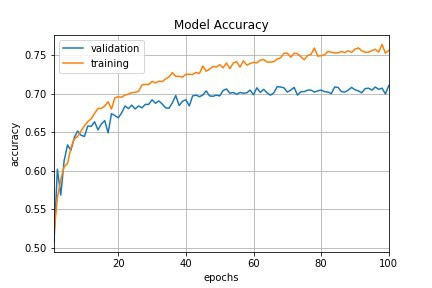

In [35]:
from IPython.display import Image
Image(filename='1.jpeg')

In [33]:
# инициализируем оптимизатор RMSprop
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
opt = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [30]:
# Будем тренировать нашу сеть, использую RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train_ = x_train_batch.astype('float32')
y_train_ = y_train_batch.astype('float32')
x_train_ /= 255
y_train_ /= 255

In [32]:
# Воспользуемся TensorBoard для наглядного просмотра процесса обучения сети
tbCallBack = keras.callbacks.TensorBoard(log_dir='Graph', histogram_freq=0,  
          write_graph=True, write_images=True)

tensorboard = TensorBoard(log_dir='/home/alex/logs_keras', histogram_freq=0,
                          write_graph=True, write_images=False)

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train_, y_train_,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test_, y_test_),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # Это будет делать предварительную обработку и увеличение данных в реальном времени:
     datagen = ImageDataGenerator (
         featurewise_center = False, # set input означает 0 по набору данных
         samplewise_center = False, # установить, что каждый образец равен 0
         featurewise_std_normalization = False, # делить входные данные на std набора данных
         samplewise_std_normalization = False, # делить каждый вход на его std
         zca_whitening = False, # применять ZCA отбеливание
         rotation_range = 0, # случайным образом поворачивать изображения в диапазоне (градусов, от 0 до 180)
         width_shift_range = 0,1, # случайным образом сдвигать изображения по горизонтали (доля от общей ширины)
         height_shift_range = 0,1, # случайное смещение изображений по вертикали (доля от общей высоты)
         horizontal_flip = True, # случайным образом переворачивает изображения
         vertical_flip = False) # случайным образом переворачивает изображения


  # Вычислить величины, необходимые для нормальной нормализации
     # (std, средний и главный компоненты, если применяется отбеливание ZCA).
    datagen.fit(x_train)

    # Будем тренировать модель на batch, сформированных с помощью datatgen.flow()
    model.fit_generator(datagen.flow(x_train_, y_train_,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test_, y_test_),
                        workers=4,
                       callbacks=[tensorboard])

# Сохранение весов
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Итоги
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

### Результат обучения


Using real-time data augmentation.

Epoch 1/100
  16/1563 [..............................] - ETA: 5:15 - loss: 2.3215 - acc: 0.06841562/1563 [============================>.] - ETA: 0s - loss: 1.8994 - acc: 0.30051563/1563 [==============================] - 299s 191ms/step - loss: 1.8991 - acc: 0.3005 - val_loss: 1.6321 - val_acc: 0.4104

Epoch 2/100
 449/1563 [=======>......................] - ETA: 3:24 - loss: 1.6735 - acc: 0.38611563/1563 [==============================] - 300s 192ms/step - loss: 1.6138 - acc: 0.4120 - val_loss: 1.4035 - val_acc: 0.4937

Epoch 3/100
  35/1563 [..............................] - ETA: 4:42 - loss: 1.5160 - acc: 0.44291562/1563 [============================>.] - ETA: 0s - loss: 1.4870 - acc: 0.46221563/1563 [==============================] - 301s 192ms/step - loss: 1.4870 - acc: 0.4623 - val_loss: 1.3070 - val_acc: 0.5337

Epoch 4/100
 449/1563 [=======>......................] - ETA: 3:24 - loss: 1.4204 - acc: 0.48641563/1563 [==============================] - 300s 192ms/step - loss: 1.4072 - acc: 0.4918 - val_loss: 1.2811 - val_acc: 0.5374

Epoch 5/100
  34/1563 [..............................] - ETA: 4:37 - loss: 1.3768 - acc: 0.51751562/1563 [============================>.] - ETA: 0s - loss: 1.3488 - acc: 0.51511563/1563 [==============================] - 299s 191ms/step - loss: 1.3487 - acc: 0.5151 - val_loss: 1.2098 - val_acc: 0.5664

Epoch 6/100
 449/1563 [=======>......................] - ETA: 3:24 - loss: 1.3219 - acc: 0.52561563/1563 [==============================] - 299s 191ms/step - loss: 1.2989 - acc: 0.5355 - val_loss: 1.1242 - val_acc: 0.5995

Epoch 7/100
  35/1563 [..............................] - ETA: 4:38 - loss: 1.2247 - acc: 0.56701562/1563 [============================>.] - ETA: 0s - loss: 1.2493 - acc: 0.55711563/1563 [==============================] - 299s 191ms/step - loss: 1.2493 - acc: 0.5571 - val_loss: 1.0849 - val_acc: 0.6137

Epoch 8/100
 449/1563 [=======>......................] - ETA: 3:22 - loss: 1.2121 - acc: 0.56651563/1563 [==============================] - 298s 191ms/step - loss: 1.2077 - acc: 0.5701 - val_loss: 1.0600 - val_acc: 0.6248

Epoch 9/100
  35/1563 [..............................] - ETA: 4:37 - loss: 1.1921 - acc: 0.58481562/1563 [============================>.] - ETA: 0s - loss: 1.1757 - acc: 0.58381563/1563 [==============================] - 298s 191ms/step - loss: 1.1758 - acc: 0.5837 - val_loss: 1.0653 - val_acc: 0.6208

Epoch 10/100
 447/1563 [=======>......................] - ETA: 3:23 - loss: 1.1526 - acc: 0.59291563/1563 [==============================] - 299s 191ms/step - loss: 1.1382 - acc: 0.5964 - val_loss: 0.9951 - val_acc: 0.6460

Epoch 11/100
  34/1563 [..............................] - ETA: 4:37 - loss: 1.1742 - acc: 0.58821562/1563 [============================>.] - ETA: 0s - loss: 1.1174 - acc: 0.60471563/1563 [==============================] - 298s 191ms/step - loss: 1.1174 - acc: 0.6048 - val_loss: 1.0137 - val_acc: 0.6396

Epoch 12/100
 447/1563 [=======>......................] - ETA: 3:23 - loss: 1.0983 - acc: 0.61061563/1563 [==============================] - 297s 190ms/step - loss: 1.0903 - acc: 0.6152 - val_loss: 0.9510 - val_acc: 0.6687

Epoch 13/100
  34/1563 [..............................] - ETA: 4:36 - loss: 1.0432 - acc: 0.64431562/1563 [============================>.] - ETA: 0s - loss: 1.0732 - acc: 0.62241563/1563 [==============================] - 298s 190ms/step - loss: 1.0731 - acc: 0.6224 - val_loss: 0.9513 - val_acc: 0.6670

Epoch 14/100
 446/1563 [=======>......................] - ETA: 3:23 - loss: 1.0717 - acc: 0.62441563/1563 [==============================] - 297s 190ms/step - loss: 1.0549 - acc: 0.6301 - val_loss: 0.9376 - val_acc: 0.6714

Epoch 15/100
  33/1563 [..............................] - ETA: 4:39 - loss: 1.0583 - acc: 0.63351562/1563 [============================>.] - ETA: 0s - loss: 1.0337 - acc: 0.63721563/1563 [==============================] - 298s 191ms/step - loss: 1.0336 - acc: 0.6373 - val_loss: 0.9282 - val_acc: 0.6731

Epoch 16/100
 447/1563 [=======>......................] - ETA: 3:24 - loss: 1.0183 - acc: 0.64701563/1563 [==============================] - 298s 191ms/step - loss: 1.0211 - acc: 0.6442 - val_loss: 0.8798 - val_acc: 0.6911

Epoch 17/100
  34/1563 [..............................] - ETA: 4:36 - loss: 1.0267 - acc: 0.65071562/1563 [============================>.] - ETA: 0s - loss: 1.0118 - acc: 0.64951563/1563 [==============================] - 298s 191ms/step - loss: 1.0117 - acc: 0.6496 - val_loss: 0.8617 - val_acc: 0.6951

Epoch 18/100
 447/1563 [=======>......................] - ETA: 3:23 - loss: 1.0119 - acc: 0.65011563/1563 [==============================] - 299s 191ms/step - loss: 1.0058 - acc: 0.6495 - val_loss: 0.8821 - val_acc: 0.6897

Epoch 19/100
  34/1563 [..............................] - ETA: 4:37 - loss: 0.9945 - acc: 0.66911562/1563 [============================>.] - ETA: 0s - loss: 0.9899 - acc: 0.65491563/1563 [==============================] - 296s 190ms/step - loss: 0.9900 - acc: 0.6550 - val_loss: 0.8892 - val_acc: 0.6919

Epoch 20/100
 447/1563 [=======>......................] - ETA: 3:23 - loss: 0.9677 - acc: 0.66421563/1563 [==============================] - 298s 191ms/step - loss: 0.9783 - acc: 0.6606 - val_loss: 0.8761 - val_acc: 0.6942

Epoch 21/100
  34/1563 [..............................] - ETA: 4:38 - loss: 0.9565 - acc: 0.67191562/1563 [============================>.] - ETA: 0s - loss: 0.9706 - acc: 0.66371563/1563 [==============================] - 298s 190ms/step - loss: 0.9706 - acc: 0.6637 - val_loss: 0.8395 - val_acc: 0.7099

Epoch 22/100
 447/1563 [=======>......................] - ETA: 3:22 - loss: 0.9482 - acc: 0.66841563/1563 [==============================] - 297s 190ms/step - loss: 0.9529 - acc: 0.6704 - val_loss: 0.8930 - val_acc: 0.6963

Epoch 23/100
  34/1563 [..............................] - ETA: 4:35 - loss: 0.9282 - acc: 0.68291562/1563 [============================>.] - ETA: 0s - loss: 0.9531 - acc: 0.67131563/1563 [==============================] - 299s 191ms/step - loss: 0.9534 - acc: 0.6713 - val_loss: 0.8476 - val_acc: 0.7198

Epoch 24/100
 447/1563 [=======>......................] - ETA: 3:23 - loss: 0.9558 - acc: 0.67051563/1563 [==============================] - 297s 190ms/step - loss: 0.9440 - acc: 0.6743 - val_loss: 0.7941 - val_acc: 0.7288

Epoch 25/100
  34/1563 [..............................] - ETA: 4:37 - loss: 0.8982 - acc: 0.70681562/1563 [============================>.] - ETA: 0s - loss: 0.9334 - acc: 0.68051563/1563 [==============================] - 298s 190ms/step - loss: 0.9334 - acc: 0.6805 - val_loss: 0.8745 - val_acc: 0.7015

Epoch 26/100
 447/1563 [=======>......................] - ETA: 3:23 - loss: 0.9389 - acc: 0.68211563/1563 [==============================] - 298s 191ms/step - loss: 0.9365 - acc: 0.6792 - val_loss: 0.7693 - val_acc: 0.7360

Epoch 27/100
  34/1563 [..............................] - ETA: 4:37 - loss: 0.8820 - acc: 0.69851562/1563 [============================>.] - ETA: 0s - loss: 0.9231 - acc: 0.68271563/1563 [==============================] - 297s 190ms/step - loss: 0.9232 - acc: 0.6826 - val_loss: 0.8236 - val_acc: 0.7178

Epoch 28/100
 447/1563 [=======>......................] - ETA: 3:21 - loss: 0.9225 - acc: 0.68481563/1563 [==============================] - 297s 190ms/step - loss: 0.9216 - acc: 0.6838 - val_loss: 0.8337 - val_acc: 0.7180

Epoch 29/100
  34/1563 [..............................] - ETA: 4:36 - loss: 0.9287 - acc: 0.68751562/1563 [============================>.] - ETA: 0s - loss: 0.9173 - acc: 0.68571563/1563 [==============================] - 297s 190ms/step - loss: 0.9171 - acc: 0.6857 - val_loss: 0.8036 - val_acc: 0.7234

Epoch 30/100
 447/1563 [=======>......................] - ETA: 3:21 - loss: 0.9343 - acc: 0.68451563/1563 [==============================] - 296s 189ms/step - loss: 0.9180 - acc: 0.6887 - val_loss: 0.7605 - val_acc: 0.7412

Epoch 31/100
  34/1563 [..............................] - ETA: 4:35 - loss: 0.8859 - acc: 0.69761331/1563 [========================>.....] - ETA: 41s - loss: 0.9150 - acc: 0.68771563/1563 [==============================] - 297s 190ms/step - loss: 0.9141 - acc: 0.6884 - val_loss: 0.7734 - val_acc: 0.7340

Epoch 32/100
 361/1563 [=====>........................] - ETA: 3:37 - loss: 0.8956 - acc: 0.69641563/1563 [==============================] - 297s 190ms/step - loss: 0.9067 - acc: 0.6917 - val_loss: 0.8185 - val_acc: 0.7241

Epoch 33/100
   2/1563 [..............................] - ETA: 4:40 - loss: 1.1569 - acc: 0.64061562/1563 [============================>.] - ETA: 0s - loss: 0.9069 - acc: 0.69301563/1563 [==============================] - 295s 189ms/step - loss: 0.9069 - acc: 0.6929 - val_loss: 0.7667 - val_acc: 0.7462

Epoch 34/100
 446/1563 [=======>......................] - ETA: 3:22 - loss: 0.9003 - acc: 0.69461563/1563 [==============================] - 298s 191ms/step - loss: 0.9063 - acc: 0.6931 - val_loss: 0.7699 - val_acc: 0.7351

Epoch 35/100
  33/1563 [..............................] - ETA: 4:36 - loss: 0.8743 - acc: 0.70551562/1563 [============================>.] - ETA: 0s - loss: 0.9012 - acc: 0.69471563/1563 [==============================] - 296s 190ms/step - loss: 0.9010 - acc: 0.6948 - val_loss: 0.7656 - val_acc: 0.7421

Epoch 36/100
 447/1563 [=======>......................] - ETA: 3:21 - loss: 0.8868 - acc: 0.69781563/1563 [==============================] - 297s 190ms/step - loss: 0.8981 - acc: 0.6950 - val_loss: 0.7864 - val_acc: 0.7335

Epoch 37/100
  34/1563 [..............................] - ETA: 4:36 - loss: 0.8894 - acc: 0.68841562/1563 [============================>.] - ETA: 0s - loss: 0.9013 - acc: 0.69521563/1563 [==============================] - 297s 190ms/step - loss: 0.9012 - acc: 0.6952 - val_loss: 0.7908 - val_acc: 0.7317

Epoch 38/100
 447/1563 [=======>......................] - ETA: 3:21 - loss: 0.9146 - acc: 0.69131563/1563 [==============================] - 296s 189ms/step - loss: 0.9010 - acc: 0.6955 - val_loss: 0.8620 - val_acc: 0.7190

Epoch 39/100
  34/1563 [..............................] - ETA: 4:33 - loss: 0.8917 - acc: 0.68841562/1563 [============================>.] - ETA: 0s - loss: 0.8879 - acc: 0.69651563/1563 [==============================] - 295s 189ms/step - loss: 0.8879 - acc: 0.6966 - val_loss: 0.8415 - val_acc: 0.7127

Epoch 40/100
 447/1563 [=======>......................] - ETA: 3:20 - loss: 0.8797 - acc: 0.70121563/1563 [==============================] - 297s 190ms/step - loss: 0.8930 - acc: 0.7002 - val_loss: 0.8540 - val_acc: 0.7383

Epoch 41/100
  33/1563 [..............................] - ETA: 4:33 - loss: 0.8908 - acc: 0.70551562/1563 [============================>.] - ETA: 0s - loss: 0.8876 - acc: 0.69931563/1563 [==============================] - 296s 189ms/step - loss: 0.8877 - acc: 0.6993 - val_loss: 0.8685 - val_acc: 0.7065

Epoch 42/100
 447/1563 [=======>......................] - ETA: 3:21 - loss: 0.8723 - acc: 0.70271563/1563 [==============================] - 296s 189ms/step - loss: 0.8835 - acc: 0.7017 - val_loss: 0.7952 - val_acc: 0.7334

Epoch 43/100
  34/1563 [..............................] - ETA: 4:36 - loss: 0.8804 - acc: 0.68661562/1563 [============================>.] - ETA: 0s - loss: 0.8902 - acc: 0.70111563/1563 [==============================] - 298s 190ms/step - loss: 0.8902 - acc: 0.7011 - val_loss: 0.8323 - val_acc: 0.7420

Epoch 44/100
 447/1563 [=======>......................] - ETA: 3:22 - loss: 0.8866 - acc: 0.70341563/1563 [==============================] - 299s 191ms/step - loss: 0.8914 - acc: 0.6992 - val_loss: 0.7948 - val_acc: 0.7314

Epoch 45/100
  34/1563 [..............................] - ETA: 4:39 - loss: 0.9090 - acc: 0.70591562/1563 [============================>.] - ETA: 0s - loss: 0.8803 - acc: 0.70231563/1563 [==============================] - 297s 190ms/step - loss: 0.8801 - acc: 0.7023 - val_loss: 0.8791 - val_acc: 0.7061

Epoch 46/100
 447/1563 [=======>......................] - ETA: 3:22 - loss: 0.8887 - acc: 0.70371563/1563 [==============================] - 297s 190ms/step - loss: 0.8890 - acc: 0.7024 - val_loss: 0.7995 - val_acc: 0.7355

Epoch 47/100
  34/1563 [..............................] - ETA: 4:35 - loss: 0.8952 - acc: 0.71141562/1563 [============================>.] - ETA: 0s - loss: 0.8850 - acc: 0.70381563/1563 [==============================] - 296s 189ms/step - loss: 0.8851 - acc: 0.7038 - val_loss: 0.7804 - val_acc: 0.7434

Epoch 48/100
 447/1563 [=======>......................] - ETA: 3:20 - loss: 0.8839 - acc: 0.70161563/1563 [==============================] - 295s 189ms/step - loss: 0.8872 - acc: 0.7020 - val_loss: 0.7527 - val_acc: 0.7517

Epoch 49/100
  34/1563 [..............................] - ETA: 4:37 - loss: 0.8725 - acc: 0.70401562/1563 [============================>.] - ETA: 0s - loss: 0.8870 - acc: 0.69981563/1563 [==============================] - 296s 189ms/step - loss: 0.8869 - acc: 0.6998 - val_loss: 0.8954 - val_acc: 0.7069

Epoch 50/100
 447/1563 [=======>......................] - ETA: 3:21 - loss: 0.8859 - acc: 0.70151563/1563 [==============================] - 296s 190ms/step - loss: 0.8851 - acc: 0.7039 - val_loss: 0.8416 - val_acc: 0.7295

Epoch 51/100
  34/1563 [..............................] - ETA: 4:30 - loss: 0.9260 - acc: 0.68661562/1563 [============================>.] - ETA: 0s - loss: 0.8857 - acc: 0.70451563/1563 [==============================] - 295s 189ms/step - loss: 0.8857 - acc: 0.7045 - val_loss: 0.7654 - val_acc: 0.7524

Epoch 52/100
 447/1563 [=======>......................] - ETA: 3:21 - loss: 0.8957 - acc: 0.69991563/1563 [==============================] - 296s 189ms/step - loss: 0.8897 - acc: 0.7018 - val_loss: 0.8329 - val_acc: 0.7388

Epoch 53/100
  34/1563 [..............................] - ETA: 4:35 - loss: 0.8854 - acc: 0.70591373/1563 [=========================>....] - ETA: 34s - loss: 0.8924 - acc: 0.70221563/1563 [==============================] - 297s 190ms/step - loss: 0.8945 - acc: 0.7013 - val_loss: 0.8075 - val_acc: 0.7445

Epoch 54/100
 378/1563 [======>.......................] - ETA: 3:34 - loss: 0.8993 - acc: 0.70041563/1563 [==============================] - 296s 190ms/step - loss: 0.8898 - acc: 0.7011 - val_loss: 0.8144 - val_acc: 0.7476

Epoch 55/100
   8/1563 [..............................] - ETA: 4:38 - loss: 0.7868 - acc: 0.73051562/1563 [============================>.] - ETA: 0s - loss: 0.8901 - acc: 0.70211563/1563 [==============================] - 296s 190ms/step - loss: 0.8901 - acc: 0.7021 - val_loss: 0.7746 - val_acc: 0.7425

Epoch 56/100
 447/1563 [=======>......................] - ETA: 3:21 - loss: 0.8975 - acc: 0.70001563/1563 [==============================] - 296s 189ms/step - loss: 0.9006 - acc: 0.7001 - val_loss: 0.8122 - val_acc: 0.7429

Epoch 57/100
  34/1563 [..............................] - ETA: 4:35 - loss: 0.8494 - acc: 0.71511562/1563 [============================>.] - ETA: 0s - loss: 0.8906 - acc: 0.70061563/1563 [==============================] - 297s 190ms/step - loss: 0.8906 - acc: 0.7006 - val_loss: 0.8257 - val_acc: 0.7446

Epoch 58/100
 447/1563 [=======>......................] - ETA: 3:22 - loss: 0.8858 - acc: 0.70181563/1563 [==============================] - 296s 189ms/step - loss: 0.8903 - acc: 0.7019 - val_loss: 0.8509 - val_acc: 0.7448

Epoch 59/100
  34/1563 [..............................] - ETA: 4:34 - loss: 0.8744 - acc: 0.70961562/1563 [============================>.] - ETA: 0s - loss: 0.8904 - acc: 0.70431563/1563 [==============================] - 296s 189ms/step - loss: 0.8904 - acc: 0.7043 - val_loss: 0.8011 - val_acc: 0.7472

Epoch 60/100
 447/1563 [=======>......................] - ETA: 3:21 - loss: 0.8693 - acc: 0.70711563/1563 [==============================] - 296s 189ms/step - loss: 0.8905 - acc: 0.7026 - val_loss: 0.8531 - val_acc: 0.7244

Epoch 61/100
  34/1563 [..............................] - ETA: 4:35 - loss: 0.8898 - acc: 0.70221562/1563 [============================>.] - ETA: 0s - loss: 0.8974 - acc: 0.70061563/1563 [==============================] - 296s 189ms/step - loss: 0.8974 - acc: 0.7005 - val_loss: 0.8019 - val_acc: 0.7307

Epoch 62/100
 447/1563 [=======>......................] - ETA: 3:21 - loss: 0.8907 - acc: 0.70631563/1563 [==============================] - 295s 189ms/step - loss: 0.9014 - acc: 0.7006 - val_loss: 0.7784 - val_acc: 0.7413

Epoch 63/100
  34/1563 [..............................] - ETA: 4:33 - loss: 0.8599 - acc: 0.72061562/1563 [============================>.] - ETA: 0s - loss: 0.8960 - acc: 0.70321563/1563 [==============================] - 295s 189ms/step - loss: 0.8959 - acc: 0.7032 - val_loss: 0.8095 - val_acc: 0.7309

Epoch 64/100
 447/1563 [=======>......................] - ETA: 3:20 - loss: 0.9132 - acc: 0.69941563/1563 [==============================] - 296s 189ms/step - loss: 0.9020 - acc: 0.7012 - val_loss: 0.8378 - val_acc: 0.7258

Epoch 65/100
  34/1563 [..............................] - ETA: 4:37 - loss: 0.8889 - acc: 0.69761562/1563 [============================>.] - ETA: 0s - loss: 0.9047 - acc: 0.70191563/1563 [==============================] - 296s 190ms/step - loss: 0.9047 - acc: 0.7019 - val_loss: 0.7881 - val_acc: 0.7383

Epoch 66/100
 447/1563 [=======>......................] - ETA: 3:21 - loss: 0.9040 - acc: 0.70251563/1563 [==============================] - 296s 190ms/step - loss: 0.9068 - acc: 0.6977 - val_loss: 0.8272 - val_acc: 0.7318

Epoch 67/100
  34/1563 [..............................] - ETA: 4:36 - loss: 0.8491 - acc: 0.71321562/1563 [============================>.] - ETA: 0s - loss: 0.9118 - acc: 0.69651563/1563 [==============================] - 296s 189ms/step - loss: 0.9118 - acc: 0.6965 - val_loss: 0.8114 - val_acc: 0.7281

Epoch 68/100
 447/1563 [=======>......................] - ETA: 3:21 - loss: 0.9185 - acc: 0.70271563/1563 [==============================] - 296s 189ms/step - loss: 0.9187 - acc: 0.6996 - val_loss: 0.7780 - val_acc: 0.7410

Epoch 69/100
  34/1563 [..............................] - ETA: 4:32 - loss: 0.9210 - acc: 0.69671363/1563 [=========================>....] - ETA: 36s - loss: 0.9161 - acc: 0.69861563/1563 [==============================] - 296s 189ms/step - loss: 0.9202 - acc: 0.6972 - val_loss: 0.9146 - val_acc: 0.7000

Epoch 70/100
 374/1563 [======>.......................] - ETA: 3:34 - loss: 0.9256 - acc: 0.69851563/1563 [==============================] - 296s 189ms/step - loss: 0.9234 - acc: 0.6939 - val_loss: 0.7972 - val_acc: 0.7490

Epoch 71/100
   7/1563 [..............................] - ETA: 4:38 - loss: 0.8817 - acc: 0.74111562/1563 [============================>.] - ETA: 0s - loss: 0.9183 - acc: 0.69731563/1563 [==============================] - 297s 190ms/step - loss: 0.9184 - acc: 0.6972 - val_loss: 0.8077 - val_acc: 0.7325

Epoch 72/100
 447/1563 [=======>......................] - ETA: 3:22 - loss: 0.9320 - acc: 0.69401563/1563 [==============================] - 297s 190ms/step - loss: 0.9311 - acc: 0.6922 - val_loss: 0.8808 - val_acc: 0.7115

Epoch 73/100
  34/1563 [..............................] - ETA: 4:34 - loss: 0.9192 - acc: 0.70501562/1563 [============================>.] - ETA: 0s - loss: 0.9352 - acc: 0.69191563/1563 [==============================] - 297s 190ms/step - loss: 0.9351 - acc: 0.6919 - val_loss: 0.8430 - val_acc: 0.7125

Epoch 74/100
 447/1563 [=======>......................] - ETA: 3:22 - loss: 0.9301 - acc: 0.69531563/1563 [==============================] - 298s 191ms/step - loss: 0.9398 - acc: 0.6890 - val_loss: 0.7665 - val_acc: 0.7491

Epoch 75/100
  34/1563 [..............................] - ETA: 4:37 - loss: 0.8916 - acc: 0.68381562/1563 [============================>.] - ETA: 0s - loss: 0.9434 - acc: 0.68831563/1563 [==============================] - 298s 190ms/step - loss: 0.9435 - acc: 0.6883 - val_loss: 0.8224 - val_acc: 0.7410

Epoch 76/100
 447/1563 [=======>......................] - ETA: 3:22 - loss: 0.9656 - acc: 0.68001563/1563 [==============================] - 298s 191ms/step - loss: 0.9474 - acc: 0.6875 - val_loss: 0.7872 - val_acc: 0.7445

Epoch 77/100
  34/1563 [..............................] - ETA: 4:39 - loss: 0.9013 - acc: 0.69671562/1563 [============================>.] - ETA: 0s - loss: 0.9572 - acc: 0.68541563/1563 [==============================] - 298s 191ms/step - loss: 0.9575 - acc: 0.6854 - val_loss: 0.9213 - val_acc: 0.6972

Epoch 78/100
 447/1563 [=======>......................] - ETA: 3:23 - loss: 0.9644 - acc: 0.68161563/1563 [==============================] - 299s 191ms/step - loss: 0.9627 - acc: 0.6839 - val_loss: 0.8086 - val_acc: 0.7313

Epoch 79/100
  34/1563 [..............................] - ETA: 4:38 - loss: 0.9119 - acc: 0.69031562/1563 [============================>.] - ETA: 0s - loss: 0.9645 - acc: 0.68241563/1563 [==============================] - 300s 192ms/step - loss: 0.9646 - acc: 0.6823 - val_loss: 0.8467 - val_acc: 0.7203

Epoch 80/100
 447/1563 [=======>......................] - ETA: 3:24 - loss: 0.9717 - acc: 0.68491563/1563 [==============================] - 299s 191ms/step - loss: 0.9680 - acc: 0.6846 - val_loss: 0.8598 - val_acc: 0.7432

Epoch 81/100
  34/1563 [..............................] - ETA: 4:37 - loss: 0.9457 - acc: 0.69121562/1563 [============================>.] - ETA: 0s - loss: 0.9789 - acc: 0.68041563/1563 [==============================] - 299s 191ms/step - loss: 0.9789 - acc: 0.6803 - val_loss: 0.8795 - val_acc: 0.7241

Epoch 82/100
 447/1563 [=======>......................] - ETA: 3:23 - loss: 0.9622 - acc: 0.68371563/1563 [==============================] - 298s 191ms/step - loss: 0.9745 - acc: 0.6804 - val_loss: 0.8255 - val_acc: 0.7196

Epoch 83/100
  34/1563 [..............................] - ETA: 4:38 - loss: 1.0080 - acc: 0.68291532/1563 [============================>.] - ETA: 5s - loss: 0.9906 - acc: 0.67611563/1563 [==============================] - 298s 191ms/step - loss: 0.9913 - acc: 0.6763 - val_loss: 0.8709 - val_acc: 0.7036

Epoch 84/100
 436/1563 [=======>......................] - ETA: 3:25 - loss: 0.9885 - acc: 0.67941563/1563 [==============================] - 299s 191ms/step - loss: 0.9999 - acc: 0.6740 - val_loss: 0.9191 - val_acc: 0.7215

Epoch 85/100
  30/1563 [..............................] - ETA: 4:37 - loss: 1.0139 - acc: 0.64581562/1563 [============================>.] - ETA: 0s - loss: 1.0039 - acc: 0.67321563/1563 [==============================] - 298s 191ms/step - loss: 1.0041 - acc: 0.6731 - val_loss: 0.8671 - val_acc: 0.7158

Epoch 86/100
 447/1563 [=======>......................] - ETA: 3:23 - loss: 1.0081 - acc: 0.67281563/1563 [==============================] - 299s 191ms/step - loss: 1.0084 - acc: 0.6715 - val_loss: 0.9526 - val_acc: 0.6859

Epoch 87/100
  34/1563 [..............................] - ETA: 4:38 - loss: 1.0246 - acc: 0.66541562/1563 [============================>.] - ETA: 0s - loss: 1.0183 - acc: 0.66691563/1563 [==============================] - 297s 190ms/step - loss: 1.0185 - acc: 0.6668 - val_loss: 0.8932 - val_acc: 0.7023

Epoch 88/100
 447/1563 [=======>......................] - ETA: 3:21 - loss: 1.0068 - acc: 0.67411563/1563 [==============================] - 297s 190ms/step - loss: 1.0174 - acc: 0.6696 - val_loss: 0.9168 - val_acc: 0.7026

Epoch 89/100
  34/1563 [..............................] - ETA: 4:37 - loss: 1.0329 - acc: 0.67831562/1563 [============================>.] - ETA: 0s - loss: 1.0197 - acc: 0.66521563/1563 [==============================] - 298s 191ms/step - loss: 1.0199 - acc: 0.6651 - val_loss: 0.8453 - val_acc: 0.7397

Epoch 90/100
 447/1563 [=======>......................] - ETA: 3:23 - loss: 1.0237 - acc: 0.66581563/1563 [==============================] - 298s 191ms/step - loss: 1.0229 - acc: 0.6662 - val_loss: 0.8722 - val_acc: 0.7208

Epoch 91/100
  34/1563 [..............................] - ETA: 4:36 - loss: 0.9789 - acc: 0.68381562/1563 [============================>.] - ETA: 0s - loss: 1.0374 - acc: 0.66171563/1563 [==============================] - 298s 190ms/step - loss: 1.0375 - acc: 0.6617 - val_loss: 0.8920 - val_acc: 0.7078

Epoch 92/100
 446/1563 [=======>......................] - ETA: 3:25 - loss: 1.0324 - acc: 0.66411563/1563 [==============================] - 299s 191ms/step - loss: 1.0332 - acc: 0.6640 - val_loss: 0.9577 - val_acc: 0.6705

Epoch 93/100
  33/1563 [..............................] - ETA: 4:39 - loss: 1.0435 - acc: 0.64111562/1563 [============================>.] - ETA: 0s - loss: 1.0453 - acc: 0.65961563/1563 [==============================] - 298s 191ms/step - loss: 1.0454 - acc: 0.6595 - val_loss: 0.8865 - val_acc: 0.7049

Epoch 94/100
 447/1563 [=======>......................] - ETA: 3:22 - loss: 1.0334 - acc: 0.66411563/1563 [==============================] - 298s 191ms/step - loss: 1.0467 - acc: 0.6614 - val_loss: 0.9400 - val_acc: 0.6834

Epoch 95/100
  34/1563 [..............................] - ETA: 4:39 - loss: 1.0888 - acc: 0.64891562/1563 [============================>.] - ETA: 0s - loss: 1.0584 - acc: 0.65591563/1563 [==============================] - 298s 191ms/step - loss: 1.0583 - acc: 0.6559 - val_loss: 1.0350 - val_acc: 0.6473

Epoch 96/100
 447/1563 [=======>......................] - ETA: 3:22 - loss: 1.0462 - acc: 0.65951563/1563 [==============================] - 297s 190ms/step - loss: 1.0617 - acc: 0.6546 - val_loss: 0.9474 - val_acc: 0.6964

Epoch 97/100
  34/1563 [..............................] - ETA: 4:37 - loss: 1.0743 - acc: 0.64251562/1563 [============================>.] - ETA: 0s - loss: 1.0657 - acc: 0.65141563/1563 [==============================] - 298s 191ms/step - loss: 1.0654 - acc: 0.6514 - val_loss: 0.9688 - val_acc: 0.6692

Epoch 98/100
 447/1563 [=======>......................] - ETA: 3:22 - loss: 1.0708 - acc: 0.65261563/1563 [==============================] - 297s 190ms/step - loss: 1.0748 - acc: 0.6518 - val_loss: 0.9277 - val_acc: 0.6952

Epoch 99/100
  34/1563 [..............................] - ETA: 4:37 - loss: 1.1129 - acc: 0.63241562/1563 [============================>.] - ETA: 0s - loss: 1.0873 - acc: 0.64741563/1563 [==============================] - 297s 190ms/step - loss: 1.0870 - acc: 0.6474 - val_loss: 0.8632 - val_acc: 0.7252

Epoch 100/100
 445/1563 [=======>......................] - ETA: 3:22 - loss: 1.0853 - acc: 0.64681563/1563 [==============================] - 296s 190ms/step - loss: 1.0809 - acc: 0.6476 - val_loss: 0.9109 - val_acc: 0.6900

Saved trained model at /content/saved_models/keras_cifar10_trained_model.h5 
 1440/10000 [===>..........................] - ETA: 12s10000/10000 [==============================] - 15s 2ms/step
Test loss: 0.9108926626205445
Test accuracy: 0.71

### Результаты при других манипуляциях с learning rate:

### keras.optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False)

Постоянная скорость обучения - это график обучения по умолчанию в оптимизаторе SGD в Keras. По умолчанию импульс и скорость распада установлены равными нулю. Трудно выбрать правильную скорость обучения. Экспериментируя с диапазоном скоростей обучения в нашем примере, lr = 0,1 показывает относительную хорошую производительность для начала. Это может служить отправной точкой для экспериментов с различными стратегиями обучения.

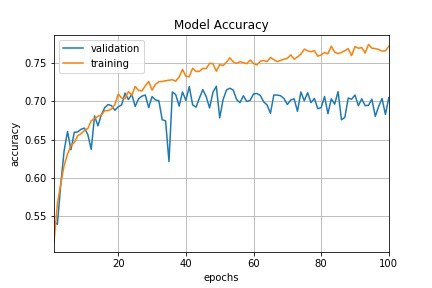

In [42]:
Image(filename='2.jpeg')

Шаг распада
График распада ступени снижает скорость обучения на каждые несколько эпох. Математическая форма ступенчатого распада:

lr = lr0 * drop ^ floor (epoch / epochs_drop)
Типичным способом является снижение скорости обучения на половину каждые 10 эпох. Чтобы реализовать это в Keras, мы можем определить функцию распада шага и использовать обратный вызов LearningRateScheduler, чтобы принять функцию разложения шагов в качестве аргумента и вернуть обновленные скорости обучения для использования в оптимизаторе SGD.

def step_decay (epoch):
   initial_lrate = 0,1
   падение = 0,5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow (drop,
           Math.floor ((1 + эпоха) / epochs_drop))
   return lrate
lrate = LearningRateScheduler (step_decay)
В качестве отступления обратный вызов представляет собой набор функций, которые должны применяться на определенных этапах учебной процедуры. Мы можем использовать обратные вызовы, чтобы получить представление о внутренних состояниях и статистике модели во время обучения. В нашем примере мы создаем пользовательский обратный вызов, расширяя базовый класс keras.callbacks.Callback для записи истории потерь и скорости обучения во время учебной процедуры.

класс LossHistory (keras.callbacks.Callback):
    def on_train_begin (self, logs = {}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end (self, batch, logs = {}):
       self.losses.append (logs.get ( «потеря»))
       self.lr.append (step_decay (LEN (self.losses)))
Собирая все вместе, мы можем передать список обратных вызовов, состоящий из обратного вызова LearningRateScheduler и нашего пользовательского обратного вызова, чтобы он соответствовал модели. Затем мы можем визуализировать график обучения и историю потерь, обратившись к loss_history.lr и loss_history.losses.

loss_history = LossHistory ()
lrate = LearningRateScheduler (step_decay)
callbacks_list = [loss_history, lrate]
history = model.fit (X_train, y_train,
   validation_data = (X_test, y_test),
   эпохи = эпоха,
   batch_size = batch_size,
   Обратные вызовы = callbacks_list,
   многословный = 2)

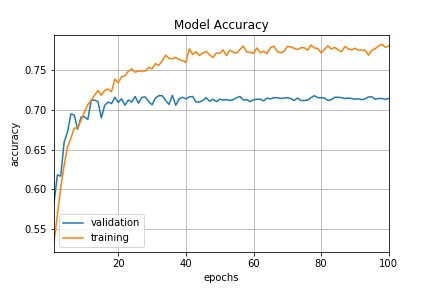

In [41]:
Image(filename='3.jpeg')